In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Pixel:
    
    def __init__(self, pos):
        """
        Square of unit side. Its center (x,y) has integer coordinates.
        At creation, the class computes also the boundaries of the pixels
        x1, x2, y1, y2.
        """
        self.x = round(pos[0])
        self.y = round(pos[1])
        self.x1 = self.x - 0.5
        self.x2 = self.x + 0.5
        self.y1 = self.y - 0.5
        self.y2 = self.y + 0.5
        
class Line:
    
    def __init__(self, p1, p2):
        """
        Line that passes between two points. Also the angular coef and intercept
        of the inverse line are computed at creation.
        """
        if p2[0] - p1[0] != 0:
            self.m = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p1[1] - self.m * p1[0]
        else:
            self.m = None
            self.b = None

        if self.m == None:
            self.m_inv = 0
            self.b_inv = p1[0]
        elif self.m != 0:
            self.m_inv = 1/self.m
            self.b_inv = -self.b/self.m
        else:
            self.m_inv = None
            self.b_inv = None      
            
    def y(self, x):
        """Position along the line at given x"""
        if self.m != None:
            return self.m * x + self.b 
        else:
            return None
    
    def x(self, y):
        """Position along the inverse line at given y"""
        if self.m_inv != None:
            return self.m_inv * y + self.b_inv 
        else:
            return None

In [3]:
def area_triangle(p1, p2, p3):
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    a, b, c = np.linalg.norm(p1-p2), np.linalg.norm(p2-p3), np.linalg.norm(p3-p1)
    s =  (a + b + c)/2
    return np.sqrt( s*(s - a)*(s - b)*(s - c) )

def area_quadrilateral(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    diag = np.linalg.norm(p1-p3)
    a, b = np.linalg.norm(p1-p2), np.linalg.norm(p2-p3)
    s =  (a + b + diag)/2
    a1 = np.sqrt( s*(s - a)*(s - b)*(s - diag) )
    a, b = np.linalg.norm(p3-p4), np.linalg.norm(p4-p1)
    s =  (a + b + diag)/2
    a2 = np.sqrt( s*(s - a)*(s - b)*(s - diag) )
    return a1 + a2

In [4]:
def area_pixel_below_line(pixel, line, orient):
    """
    It computes the area within the pixel below the line.
    In the case of vertical line the are computed is on the right of the line.
    """
    x1, x2, y1, y2 = pixel.x1, pixel.x2, pixel.y1, pixel.y2
    l_x1 = line.y(x1)
    l_x2 = line.y(x2)
    l_y1 = line.x(y1)
    l_y2 = line.x(y2)
    
    area = 1
    if line.m == None:
        area = x2 - line.b_inv
        
    elif line.m >= 1:
        if l_x2 < y1:
            area = 0
        elif l_x2 < y2:
            area = (l_x2 - y1) * (x2 - l_y1) * 0.5
        elif l_x1 < y1:
            area = x2 - l_y2 + (l_y2 - l_y1) * 0.5
        elif l_x1 < y2:
            area = 1 - (y2 - l_x1) * (l_y2 - x1) * 0.5
        
    elif line.m >= 0:
        if l_x2 < y1:
            area = 0
        elif l_x1 < y1:
            area = (l_x2 - y1) * (x2 - l_y1) * 0.5
        elif l_x2 < y2:
            area = l_x1 - y1 + (l_x2 - l_x1) * 0.5
        elif l_x1 < y2:
            area = 1 - (y2 - l_x1) * (l_y2 - x1) * 0.5
        
    elif line.m >= -1:
        if l_x1 < y1:
            area = 0
        elif l_x2 < y1:
            area = (l_x1 - y1) * (l_y1 - x1) * 0.5
        elif l_x1 < y2:
            area = l_x2 - y1 + (l_x1 - l_x2) * 0.5
        elif l_x2 < y2:
            area = 1 - (y2 - l_x2) * (x2 - l_y2) * 0.5

    else:
        if l_x1 < y1:
            area = 0
        elif l_x1 < y2:
            area = (l_x1 - y1) * (l_y1 - x1) * 0.5
        elif l_x2 < y1:
            area = l_y2 - x1 + (l_y1 - l_y2) * 0.5
        elif l_x2 < y2:
            area = 1 - (y2 - l_x2) * (x2 - l_y2) * 0.5
    
    if orient:
        return area
    else:
        return 1 - area

In [5]:
dx_th = 1e-8

def find_intersection(pixel, point, adj_point, line):
    """
    It finds the intersection of the line connecting the point inside the pixel
    to the adj_point with a border of the pixel.
    It return an integer specifying the side of the pixel intersecting the line
    (0 -> north, 1 -> west, 2 -> south, 3 -> east) and the point of 
    the intersection (only the non trivial coordinate).
    """
    dx = point[0] - adj_point[0]
    dy = point[1] - adj_point[1]
    
    if dx >= dx_th:
        l_x1 = line.y(pixel.x1)
        if dy >= dx_th:
            if l_x1 < pixel.y1:
                return 2, line.x(pixel.y1)
            else:
                return 1, l_x1
        elif dy < dx_th and dy > -dx_th:
            return 1, point[1]
        else:
            if l_x1 > pixel.y2:
                return 0, line.x(pixel.y2)
            else:
                return 1, l_x1 
    elif dx < dx_th and dx > -dx_th:
        if dy > 0:
            return 2, point[0]
        else:
            return 0, point[0]
    else:
        l_x2 = line.y(pixel.x2)
        if dy > dx_th:
            if l_x2 < pixel.y1:
                return 2, line.x(pixel.y1)
            else:
                return 3, l_x2
        elif dy < dx_th and dy > -dx_th:
            return 3, point[1]
        else:
            if l_x2 > pixel.y2:
                return 0, line.x(pixel.y2)
            else:
                return 3, l_x2


def area_pixel_below_poligon(pixel, line_in, point_in, line_out, point_out, inner_points):
    """
    It compute the area within the pixel on the right of the broken line that starts from line_in,
    connects all the inner_points and exit though line_out
    """
    
    def get_extreme_val(side_i):
        if side_i == 0:
            return pixel.x1
        elif side_i == 1:
            return pixel.y1
        elif side_i == 2:
            return pixel.x2
        else:
            return pixel.y2
        
    def get_height(side_i):
        if side_i == 0:
            return pixel.y2 - inner_points[0][1]
        elif side_i == 1:
            return inner_points[0][0] - pixel.x1
        elif side_i == 2:
            return inner_points[0][1] - pixel.y1
        else:
            return pixel.x2 - inner_points[0][0]
        
    def get_coords_on_border(side_i, coord):
        if side_i == 0:
            return np.array([coord, pixel.y2])
        elif side_i == 1:
            return np.array([pixel.x1, coord])
        elif side_i == 2:
            return np.array([coord, pixel.y1])
        else:
            return np.array([pixel.x2, coord])
        
    def remaining_area():
        if len(inner_points) == 1:
            return 0
        elif len(inner_points) == 2:
            point_border = get_coords_on_border(side_out, val_out)
            return area_triangle(inner_points[0], inner_points[1], point_border)
        elif len(inner_points) == 3:
            point_border = get_coords_on_border(side_out, val_out)
            return area_quadrilateral(inner_points[0], inner_points[1], inner_points[2], point_border)
        else:
            raise Exception('invalid inner_points length')
        
    #print('in', line_in.m, line_in.m_inv)
    side_in, val_in = find_intersection(pixel, inner_points[0], point_in, line_in)
    #print('out', line_out.m, line_out.m_inv)
    side_out, val_out = find_intersection(pixel, inner_points[-1], point_out, line_out)
    
    if side_in == side_out:
        area = abs(val_in - val_out) * get_height(side_in) * 0.5
        return area + remaining_area()
    else:
        area = abs(get_extreme_val(side_in) - val_in) * get_height(side_in)
        #print(get_extreme_val(side_in), get_height(side_in), area)
        area += (1 - abs(get_extreme_val(side_out) - val_out)) * get_height(side_out)
        #print(get_extreme_val(side_out), get_height(side_out), area)
        
        for _ in range(4):
            side_in = (side_in + 1)%4
            if side_in == side_out:
                break
            area += get_height(side_in)
        #print(area)
        
        return area * 0.5 + remaining_area()

In [13]:

    

                        
def antialiased_shape(shape):
    
    pixels = -np.ones((round(max(shape[:,1]))-round(min(shape[:,1]))+1, round(max(shape[:,0]))-round(min(shape[:,0]))+1))
    pixel_offset = round(min(shape[:,1])), round(min(shape[:,0]))
    round_shape = np.round(shape)
    close_shape = np.row_stack((shape, shape[0]))
        
    def make_side_in(n_px, px_offset, axis):
        sides_in = []
        for i in range(n_px):
            pi = i+px_offset
            sides_in_aux = []
            for ii in range(len(shape)):
                next_ii = (ii+1)%len(shape)
                if shape[ii,axis] <= shape[next_ii,axis]:
                    if pi >= round_shape[ii,axis] and pi <= round_shape[next_ii,axis]:
                        sides_in_aux.append((ii, next_ii))
                else:
                    if pi <= round_shape[ii,axis] and pi >= round_shape[next_ii,axis]:
                        sides_in_aux.append((ii, next_ii))
            sides_in.append(sides_in_aux)
        return sides_in
         
    
    def check_internal(x_sides_in):
        n_ext, n_tot = 0, 0
        for x_side in x_sides_in:
            a = area_pixel_below_line(px, lines[x_side[0]], orients[x_side[0]])
            #print(a)
            if a == 0:
                n_ext += 1
                n_tot += 1
            if a == 1:
                n_tot += 1
        #print('ext', n_ext, n_tot)
        if n_tot == 0:
            return True
        else:
            return n_ext/n_tot < 0.5
        
    def find_sides(i,j):
        sides = []
        for y_side in y_sides_in[i]:
            for x_side in x_sides_in[j]:
                if x_side[0] == y_side[0] and x_side[1] == y_side[1]:
                    sides.append(x_side)
        return sides
                        
    def check_internal2(i, j):
        print('check_int2', i, j)
        check_left = True
        i_check = i - 1
        for _ in range(len(pixels)):
            if i_check < 0:
                check_left = False
                i_check = i + 1
            elif i_check == len(pixels):
                print('Error in check_internal2')
                return False
                
            
            p = pixels[i_check, j]
            print(i_check, p)
            
            if p == 0:
                return False
            elif p == 1:
                return True
            elif p > 0:
                px = Pixel([i+pixel_offset[0], j+pixel_offset[1]])
                side = find_sides(i_check,j)[0]
                print(area_pixel_below_line(px, lines[side[0]], orients[side[0]]))
                if area_pixel_below_line(px, lines[side[0]], orients[side[0]]) == 1:
                    return True
                else:
                    return False
            # else the pixel is not been checked yet, p=-1
            
            if check_left:
                i_check -= 1
            else:
                i_check += 1
                
        print('Error in check_internal2')
        return False
            
    y_sides_in = make_side_in(len(pixels), pixel_offset[0], 1)
    #print(y_sides_in)
    x_sides_in = make_side_in(len(pixels[0]), pixel_offset[1], 0)
    #print(x_sides_in)
    
    lines = []
    for i in range(len(close_shape)-1):
        lines.append(Line(close_shape[i], close_shape[i+1]))

    orients = []
    for i in range(len(shape)):
        o = shape[(i+1)%len(shape)][0] >= shape[i][0]
        if shape[(i+1)%len(shape)][0] == shape[i][0]:
            o = shape[(i+1)%len(shape)][1] > shape[i][1]
        orients.append(o)
    
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            pi, pj = i+pixel_offset[0], j+pixel_offset[1]
            px = Pixel([pj, pi])

            sides = find_sides(i,j)
            #print(pi, pj, sides)
                    
            if len(sides) == 1:
                if check_internal(x_sides_in[j]):
                    pixels[i,j] = area_pixel_below_line(px, lines[sides[0][0]], orients[sides[0][0]])
                else:
                    pixels[i,j] = 0
                #print ('single segm', pixels[i,j], orients[sides[0][0]])

            else:
                in_i, out_i = -1, -1
                for s in sides:
                    if round_shape[s[0]][0] == px.x and round_shape[s[0]][1] == px.y and \
                        (round_shape[s[1]][0] != px.x or round_shape[s[1]][1] != px.y):
                        out_i = s[1]
                    elif round_shape[s[1]][0] == px.x and round_shape[s[1]][1] == px.y and \
                        (round_shape[s[0]][0] != px.x or round_shape[s[0]][1] != px.y):
                        in_i = s[0]
                        
                #print('in out', in_i, out_i)
                
                if in_i > -1:
                    aux_out_i = out_i
                    if out_i <= in_i:
                        aux_out_i += len(shape)
                    points = [shape[k%len(shape)] for k in range(in_i+1, aux_out_i)]
                    a = area_pixel_below_poligon(px, lines[in_i], shape[in_i], lines[out_i-1], shape[out_i], points)
                    #print('common', a)
                    pixels[i,j] = a
                else:
                    a = 0
                    for s in sides:
                        a += area_pixel_below_line(px, lines[s[0]], orients[s[0]])
                    pixels[i,j] = a - len(sides) + 1
                    
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            pi, pj = i+pixel_offset[0], j+pixel_offset[1]
            px = Pixel([pj, pi])

            sides = find_sides(i,j)
            if len(sides) == 0:
                if check_internal2(i,j):
                    pixels[i,j] = 1
                else:
                    pixels[i,j] = 0
            
    return pixels, pixel_offset

In [7]:
#shape = np.array([[3,0],[1,1.6],[2,4.5],[4.4,3],[5,1]])
shape = np.array(np.array([[31.75, 58.91], [31.29, 59.80],
                       [40.8, 61.99], [40, 61.01]]))
#shape = np.array([[3,0],[2.1,1.1],[2,2],[1.1,2.1],[0,3],[0,6],[6,6],[5,5],[6,0]])
pixels, offsets = antialiased_shape(shape)

check_int2 0 10
1 0.0


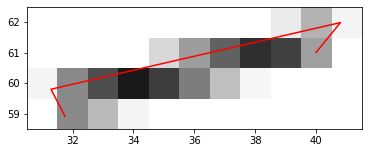

In [8]:
plt.plot(shape[:,0],shape[:,1], c='r')
plt.imshow(pixels, cmap='binary', origin='lower', vmin=0, vmax=1,
           extent=(offsets[1]-0.5, offsets[1]+len(pixels[0])-0.5, offsets[0]-0.5, offsets[0]+len(pixels)-0.5))

In [9]:
l = Line([6,6],[5,3])
px = Pixel([5,4])
area_pixel_below_line(px, l, False)

0.833333333333333

In [14]:
quads = [np.array([[0.2,0.3], [1.2,3.2], [5,3.7], [3.2,1]])]
quads.append(np.array([[2,3.6], [1.6,4], [2,4.4], [2.4,4]]))
quads.append(np.array([[2.9,3.3], [1,6.7], [6,5.2], [4.2,3.8]]))
quads.append(np.array([[0.25,0.25], [0.25,2.4], [2.25,2.4], [2.25,0.25]]))
quads.append(np.array([[1,6], [3,9], [7,6], [4,2]]))
quads.append(np.array([[0.6, 4], [1.4,4.1], [3.4,0.4], [2.6,-0.4]]))
quads.append(np.array([[0,-0.4], [0,0.4], [2,0.4], [2,-0.4]]))
quads.append(np.array([[-0.4,-0.4], [-0.4,0.45], [2,0.4], [0.45,-0.3]]))
quads.append(np.array([[0,-0.4], [-0.4,0.45], [2,2], [0.45,-0.3]]))
quads.append(np.array([[31.75, 58.91], [31.29, 59.80],
                       [40.8, 61.99], [40, 61.01]]))

In [15]:
def run():
    for _ in range(1):
        pixels = []
        offsets = []
        for q in quads:
            p, o = antialiased_shape(q)
            pixels.append(p)
            offsets.append(o)
    return pixels, offsets

%time pixels, offsets = run()

check_int2 0 4
1 0.0008333333333333526
1
check_int2 0 5
1 0.0
check_int2 2 2
1 0.78
1
check_int2 4 0
3 0.0
check_int2 0 4
1 0.1399999999999999
1
check_int2 0 5
1 0.0
check_int2 1 1
0 0.25
1
check_int2 0 10
1 0.0
Wall time: 11 ms


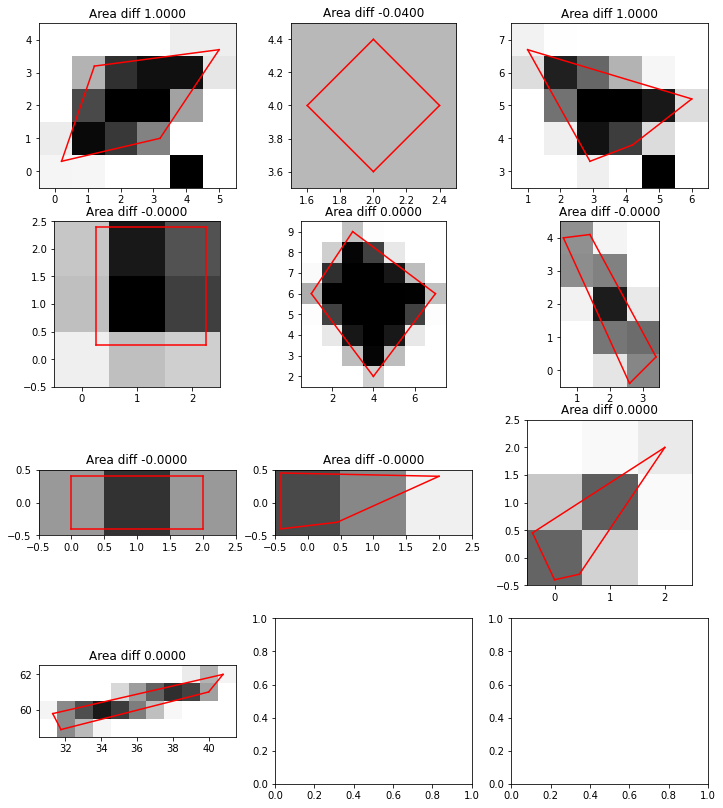

In [12]:
n_rows = int(len(quads)/3)+1
fig, axs = plt.subplots(n_rows, 3, figsize=(12,n_rows*3.5))

count=0
for k in range(len(quads)):
    i,j = k%3, int(k/3)
    d = pixels[k].sum()-area_quadrilateral(quads[k][0],quads[k][1],quads[k][2],quads[k][3])
    axs[j][i].set_title('Area diff %5.4f'%d)
    for l in range(4):
        axs[j][i].plot([quads[k][l,0], quads[k][(l+1)%4,0]], [quads[k][l,1], quads[k][(l+1)%4,1]], c='r')

    axs[j][i].imshow(pixels[k], cmap='binary', origin='lower', vmin=0, vmax=1,
               extent=(offsets[k][1]-0.5, offsets[k][1]+len(pixels[k][0])-0.5, offsets[k][0]-0.5, offsets[k][0]+len(pixels[k])-0.5))

In [157]:
def circle(center, radius, t1=0, t2=2*np.pi, steps=1000):
    thetas = np.linspace(t1, t2, steps)[::-1]
    return (np.array([[np.cos(t), np.sin(t)] for t in thetas])*radius + np.array(center)).T

In [158]:
c = circle([0,0], 2, steps=20).T
p, o = antialiased_shape(c)

-2 -2 []
0
0.007297102582488835
0.47272260680544553
1
1
ext 1 3
-2 -1 [(5, 6), (6, 7)]
-2 0 [(3, 4), (4, 5), (5, 6)]
-2 1 [(2, 3), (3, 4)]
-2 2 [(2, 3)]
0.16625902757352695
0
0
1
1
0.833740972426473
0.5
ext 2 4
-1 -2 [(7, 8), (8, 9)]
-1 -1 [(6, 7), (7, 8)]
-1 0 []
1
1
1
1
1
1
ext 0 6
-1 1 [(2, 3)]
0.978380139963625
0.9999835345563944
1
1
ext 0 2
-1 2 [(0, 1), (1, 2), (2, 3)]
0 -2 [(8, 9), (9, 10), (10, 11)]
0 -1 []
1
1
1
1
1
1
ext 0 6
0 0 []
1
1
1
1
1
1
ext 0 6
0 1 []
1
1
1
1
ext 0 4
0 2 [(0, 1), (18, 19), (19, 0)]
1 -2 [(10, 11), (11, 12)]
1 -1 [(11, 12), (12, 13)]
1 0 []
1
1
1
1
1
1
ext 0 6
1 1 [(16, 17)]
1
1
0.9999835345563944
0.978380139963625
ext 0 2
1 2 [(16, 17), (17, 18), (18, 19)]
2 -2 []
1
1
0.4727226068054442
0.007297102582488887
0
ext 1 3
2 -1 [(12, 13), (13, 14)]
2 0 [(13, 14), (14, 15), (15, 16)]
2 1 [(15, 16), (16, 17)]
2 2 [(16, 17)]
0.833740972426473
1
1
0
0
0.16625902757352695
0.5
ext 2 4


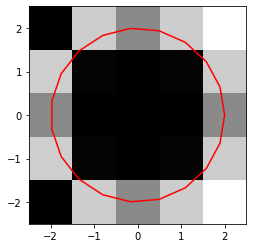

In [151]:
plt.plot(c[:,0],c[:,1], c='r')
plt.imshow(p, cmap='binary', origin='lower', vmin=0, vmax=1, extent=(o[1]-0.5, o[1]+len(p[0])-0.5, o[0]-0.5, o[0]+len(p)-0.5))